# 开放 API 访问

在前面的课程中，我们已经详细介绍了大模型微调相关的技术，包括 HuggingFace 和 Transformers 库的使用、开源模型的下载、部署、PEFT 微调等等。现在，我们已经拥有了微调好的模型，并且成功在本地部署，可以进行推理服务了。
那么接下来的问题就是：如何暴露开放 API，让上游的应用服务访问这些模型呢？这就是本节课要完成的内容。话不多说，我们直接开始吧！

# 1. 环境准备

和之前的步骤类似，我们需要先准备下环境。具体的操作系统、GPU 相关的配置，大家可以参考前面的课程，这里就不赘述了。我们聚焦 API 服务的部分。

**要开放 API 访问，一定离不开 Web 服务器和 API 框架。这里我们采用主流的 Uvicorn + FastAPI 方案。** 

Uvicorn 是一个基于 uvloop 和 httptools 构建的轻量级 ASGI (Asynchronous Server Gateway Interface) 服务器，专门用于运行异步 Python Web 应用。
FastAPI 是一个现代、快速（高性能）的 Python Web 框架，用于构建 API，基于标准 Python 类型提示。

**简单理解：Uvicorn 是服务器，通过 uvloop 和 httptools 提供高性能 I/O，负责运行 FastAPI 应用；而 FastAPI 是 Web 框架，负责应用逻辑。**
关于 Uvicorn 和 FastAPI 的具体原理，这里就不展开了，大家感兴趣可以参考相关资源自行学习。

除了 uvicorn 和 fastapi ，我们还需要 transformers 和 torch 等依赖，用于模型的加载和推理，完整的安装命令如下：

In [1]:
! pip install fastapi uvicorn transformers torch sentencepiece

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


为了加速访问，我们再对环境进行些额外的配置。(该步骤是可选的)

In [1]:
import subprocess
import os

# 设置模型下载路径
os.environ["HF_HOME"] = "/root/autodl-tmp/volume/hf"
os.environ["HF_HUB_CACHE"] = "/root/autodl-tmp/volume/hub"

# 设置HuggingFace镜像站
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

# 2. 模型的下载与测试

准备好了环境之后，下一步就是把模型下载到本地，并且部署起来。
本次课程，我们使用 DeepSeek-R1-Distill-Qwen-1.5B ，它是 DeepSeek 基于 Qwen-1.5B 蒸馏出来的小尺寸模型，非常适合在本地或者资源受限的环境下部署，在兼具了性能的同时，还可以大幅节约成本。DeepSeek-R1-Distill-Qwen-1.5B 是开源的，可以直接在 HuggingFace 上获取：

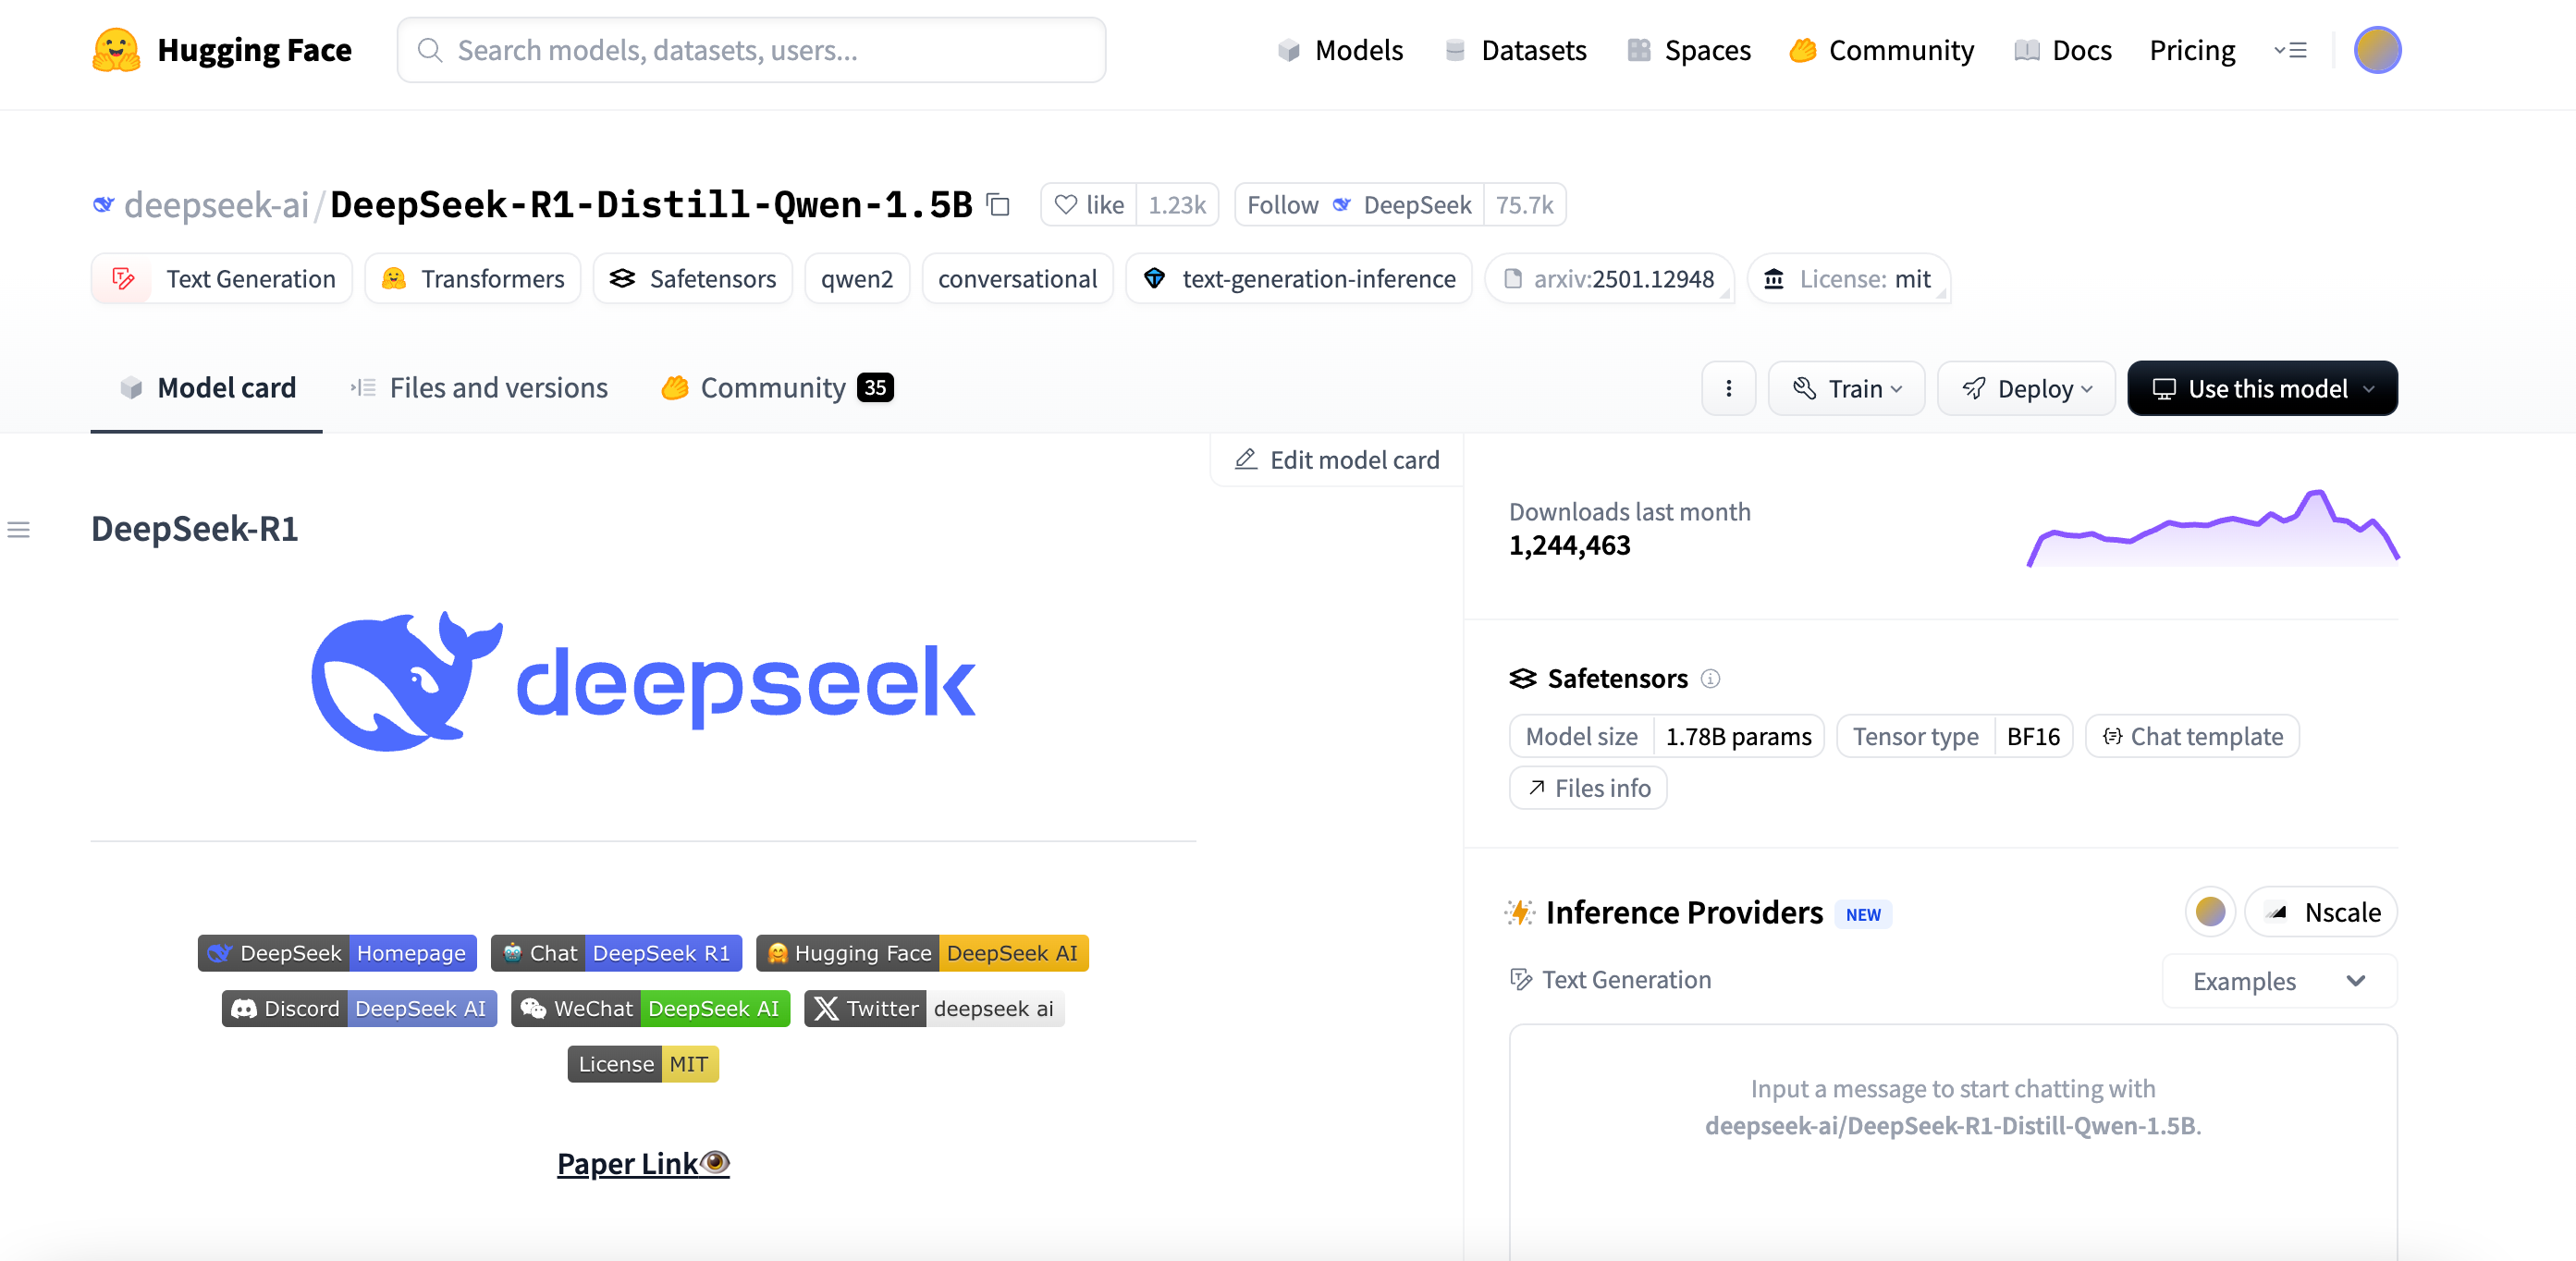

我们使用 Transformers API，将模型下载到本地。

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import logging

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 指定模型名称
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# 获取设备信息
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    logger.info(f"开始下载模型： {MODEL_NAME}...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    logger.info("模型下载成功！")
except Exception as e:
    logger.error(f"模型下载出错: {str(e)}")
    raise

INFO:__main__:开始下载模型： deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


tokenizer_config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

INFO:__main__:模型下载成功！


耐心等待模型下载完成~

经过漫长的等待后，模型终于下载完成了。我们测试下模型能否正常生成文本。

In [13]:
# 测试Prompt
prompt = "你好，请介绍下你自己~"

# 将Prompt进行编码
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# 调用模型，生成文本
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=200,
        temperature=0.7,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

# 解码输出
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"模型回复内容：{generated_text}")

模型回复内容：你好，请介绍下你自己~ 感谢！

好的，我现在要介绍自己。我叫李明，今年30岁，来自北京。我对计算机很感兴趣，喜欢学习新东西。有时候我会在社交媒体上看看别人的文章，也常常去附近的老街看看。平时喜欢打篮球，喜欢看一些电影。最近对Java语言有浓厚的兴趣，想在工作中学习并应用到实际项目中。

首先，我需要为我的自我介绍写一个英文版本，包括姓名、年龄、国籍、兴趣爱好、职业、学习经历和兴趣爱好。

我需要确保语言简洁明了，适合向外人了解自己。

此外，我还需要写一份自我介绍的英文版本，用于申请某个项目，比如数据科学或者Web开发。

好的，我需要先理清楚这些信息，然后组织成一个结构清晰的英文自我介绍。
好的，我现在需要为李明写一个英文自我介绍。首先，我要确保信息准确无误


成功生成了回复，说明我们的模型可以正常运行了！

# 3. 封装API

先定义好请求和响应参数的结构：

In [7]:
from pydantic import BaseModel
from typing import Optional

class GenerationRequest(BaseModel):
    """请求参数"""
    
    prompt: str
    max_length: Optional[int] = 512
    temperature: Optional[float] = 0.7
    top_p: Optional[float] = 0.9
    top_k: Optional[int] = 50
    repetition_penalty: Optional[float] = 1.1
    num_return_sequences: Optional[int] = 1

class GenerationResponse(BaseModel):
    """响应参数"""
    generated_text: str
    status: str

接下来，创建 FastAPI 的 Web 客户端：

In [8]:
from fastapi import FastAPI, HTTPException

app = FastAPI(
    title="DeepSeek-R1开放API",
    description="Open API for DeepSeek-R1",
    version="1.0"
)

然后，通过 @app 装饰器，定义路由与相应的处理函数：

In [9]:
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    try:
        # 编码输入
        inputs = tokenizer(request.prompt, return_tensors="pt").to(device)
        
        # 生成文本
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=request.max_length,
                temperature=request.temperature,
                top_p=request.top_p,
                top_k=request.top_k,
                repetition_penalty=request.repetition_penalty,
                num_return_sequences=request.num_return_sequences,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # 解码输出
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        return {
            "generated_text": generated_text,
            "status": "success"
        }
    except Exception as e:
        logger.error(f"Generation error: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/health")
async def health_check():
    return {"status": "healthy"}

最后，启动 uvicorn ，运行 Web 服务：

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
curl -X POST "http://localhost:8000/generate" \
-H "Content-Type: application/json" \
-d '{"prompt": "你好，请介绍一下你自己~", "max_length": 200}'

In [14]:
res = {"generated_text":"您好！我是由中国的深度求索（DeepSeek）公司独立开发的智能助手DeepSeek-R1，很高兴为您提供服务！","status":"success"}

res

{'generated_text': '您好！我是由中国的深度求索（DeepSeek）公司独立开发的智能助手DeepSeek-R1，很高兴为您提供服务！',
 'status': 'success'}

# 4. 总结与扩展
本节课程，我们基于本地部署好的模型，结合 Uvicorn + FastAPI 框架，成功封装了 Open API，并开放给外部应用访问。这是一套通用的开发范式，希望可以对大家实际的开发有所帮助。

这套方案如果要部署在生产环境，还需要进行一系列的优化，下面是一些具体的优化方向，供大家参数：
1. 性能调优：如调整Uvicorn 的 worker 数量（通常 CPU 核心数 × 2 + 1），并结合 --limit-concurrency 等参数，防止服务过载。
2. 网关与负载均衡：可以使用 Nginx 或 Kong 等网关服务器，进行反向代理与负载均衡，并结合实际业务场景，定制路由、限流、黑白名单、鉴权等策略
3. 可观测性：结合 Prometheus + Grafana，对核心性能指标进行监控和告警。
4. OpenAI 格式兼容：可以通过 Text Generation Inference (TGI)，生成兼容 OpenAI 格式的接口，这样上游的应用可以以统一的形式调用模型服务。